# Import modules

Firstly, let's import the modules that we will work with

In [1]:
import xarray as xr # For creating a NetCDF file
from datetime import datetime as dt # Handline dates and times
import uuid # Creating a universally unique identifier (UUID) for your file
import pandas as pd # Importing tabular data from a file (e.g. XLSX, CSV)
import numpy as np # Working with arrays of data and mathematical functions

# Importing your data

### From CSV/Excel to a dataframe

In [2]:
# df = pd.read_csv('/path/to/your/file.csv') # CSV files
# df = pd.read_excel('/path/to/your/file.xlsx', sheet_name='Sheet1') # Excel file

# Initialising your xarray dataset object

The first step is to create an empty xarray dataset object. 

In [3]:
xrds = xr.Dataset()
print(xrds)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*


Right away we can see the object has a defined structure with dimensions and variables. A key feature of a NetCDF file is that there is a defined structure so your data and metadata will always be in the same place within the file. This makes it easier for a machine to read it. We will add more types of data and metadata to this object as we go.

# Dimensions and coordinate variables

Dimensions define the shape of your data. Variables (your data) can be assigned one or more dimensions. A dimension in most cases is a spatial or temporal dimension (e.g. time, depth, latitude, longitude) but could also be something else (e.g. iteration, number of vertices for data representative of cells).

Dimensions tell you how many points you have for each coordinate. Coordinate variables tell you what the values for those points are.

Let's imagine a few simple scenarios. I'll initialise new xarray dataset objects each time.

### Our data is a time series with 10 points in time.

In [4]:
time = [0,1,2,3,4,5,6,7,8,9]

xrds = xr.Dataset(
    coords = {
        'time': time
    }
)

print(xrds)

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    *empty*


The object has a dimension of length 10 and a coordinate variable (time) which has a dimension of time. The values are all integers. Some more examples. 

### Your times are timestamps

There are specific recommendations on how time should be stored in NetCDF-CF files. I will try to explain briefly here, and there is a nice explanation here too: https://www.unidata.ucar.edu/software/netcdf/time/recs.html

It is most common to have a dimension named "time" as well as a coordinate variable with the same name. Let's discuss the variable first.

The "time" variable has units that count from a user defined origin, for example "hours since 2020-01-01 00:00 UTC" or "days since 2014-01-01". The units may be in years, days, seconds, nanoseconds, etc. Whilst this approach may seem strange at a glance, it allows the times to be stored in conventional numerical formats such as integers or floats, and to our desired precision. This is much more efficient than using a long timestamp string for each coordinate.

Some softwares know how to interpret this and will convert the data into timestamps in when you extract the data from a CF-NetCDF file.

In [5]:
# Creating an array of timestamps
start = np.datetime64('2022-01-01T00:00:00')
end = start + np.timedelta64(24, 'h')
timestamps = np.arange(start, end, np.timedelta64(1, 'h'))

print(timestamps)

['2022-01-01T00:00:00' '2022-01-01T01:00:00' '2022-01-01T02:00:00'
 '2022-01-01T03:00:00' '2022-01-01T04:00:00' '2022-01-01T05:00:00'
 '2022-01-01T06:00:00' '2022-01-01T07:00:00' '2022-01-01T08:00:00'
 '2022-01-01T09:00:00' '2022-01-01T10:00:00' '2022-01-01T11:00:00'
 '2022-01-01T12:00:00' '2022-01-01T13:00:00' '2022-01-01T14:00:00'
 '2022-01-01T15:00:00' '2022-01-01T16:00:00' '2022-01-01T17:00:00'
 '2022-01-01T18:00:00' '2022-01-01T19:00:00' '2022-01-01T20:00:00'
 '2022-01-01T21:00:00' '2022-01-01T22:00:00' '2022-01-01T23:00:00']


In [6]:
# In CF-NetCDF, time is stored in e.g. seconds since 2022-01-01T00:00:00Z, hours since 2022-01-01T00:00:00Z
seconds_since_start = (timestamps - start).astype('int')
hours_since_start = (timestamps - start).astype('timedelta64[h]').astype('int')

print(seconds_since_start)
print(hours_since_start)

[    0  3600  7200 10800 14400 18000 21600 25200 28800 32400 36000 39600
 43200 46800 50400 54000 57600 61200 64800 68400 72000 75600 79200 82800]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [7]:
# Add them to an xarray object

xrds = xr.Dataset(
    coords = {
        'time': seconds_since_start
        }
    )

print(xrds)

<xarray.Dataset>
Dimensions:  (time: 24)
Coordinates:
  * time     (time) int64 0 3600 7200 10800 14400 ... 72000 75600 79200 82800
Data variables:
    *empty*


### We have multiple dimensions

In [8]:
depth = [0,10,20,50,100]
latitude = [78.5425, 79.1423, 80.7139]
longitude = [30.0131,28.7269]

xrds = xr.Dataset(
    coords = {
        'depth': depth,
        'latitude': latitude,
        'longitude': longitude
    }
)

print(xrds)

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth      (depth) int64 0 10 20 50 100
  * latitude   (latitude) float64 78.54 79.14 80.71
  * longitude  (longitude) float64 30.01 28.73
Data variables:
    *empty*


# Data Variables

Now let's add some data variables. Starting from the xarray dataset object created directly above that has multiple dimensions.

You can choose what name you assign for each variable. This is not standardised, but be sensible and clear. I will show you how to make your data variables conform to the CF conventions using variable attributes in the next section

### 1D array, e.g. a depth profile

<xarray.Dataset>
Dimensions:        (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth          (depth) int64 0 10 20 50 100
  * latitude       (latitude) float64 78.54 79.14 80.71
  * longitude      (longitude) float64 30.01 28.73
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2


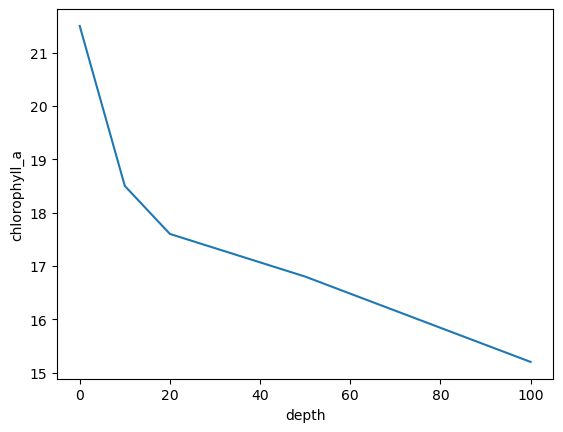

In [9]:
chlorophyll_a = [21.5, 18.5, 17.6, 16.8, 15.2] # Must be same length as the depth dimension

xrds['chlorophyll_a'] = ("depth", chlorophyll_a)

print(xrds)
xrds['chlorophyll_a'].plot()

### 2D array, e.g. a grid of latitude and longitudes

In [10]:
wind_speed = np.random.randint(0, 10, size=(3, 2))    # Creating a 2D array
print(wind_speed)

[[5 6]
 [3 9]
 [7 7]]


In [11]:
xrds['wind_speed'] = (["latitude", "longitude"], wind_speed)
print(xrds)

<xarray.Dataset>
Dimensions:        (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth          (depth) int64 0 10 20 50 100
  * latitude       (latitude) float64 78.54 79.14 80.71
  * longitude      (longitude) float64 30.01 28.73
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 5 6 3 9 7 7


Now you can see that the wind_speed variable has two dimensions; latitude and longitude. It appears as a 1D array above, but it we retrieve it we see that it isn't.

In [12]:
xrds['wind_speed']

<xarray.DataArray 'wind_speed' (latitude: 3, longitude: 2)>
array([[5, 6],
       [3, 9],
       [7, 7]])
Coordinates:
  * latitude   (latitude) float64 78.54 79.14 80.71
  * longitude  (longitude) float64 30.01 28.73

This is another major advantage of NetCDF files over tabular data formats like CSV or XLSX, which are limited in their ability to store multi-dimensional data. This multidimensional array can be used by code and software as it is without having to do any pre-processing. For example, let's plot our data

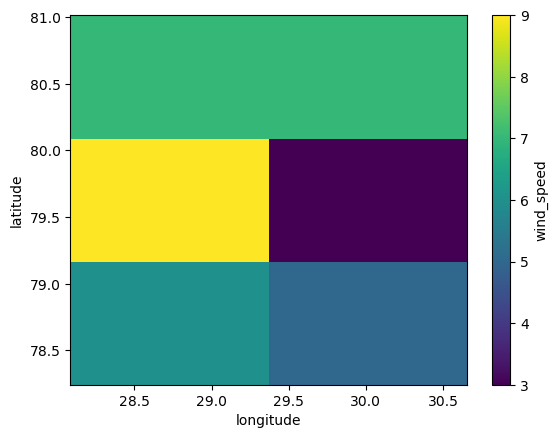

In [13]:
xrds['wind_speed'].plot.imshow(x='longitude', y='latitude')

### Example of 3D data

In [14]:
temperature = np.random.randint(20,30, size=(3,2,5))

xrds['temperature'] = (["latitude", "longitude", "depth"], temperature)
print(xrds)

<xarray.Dataset>
Dimensions:        (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth          (depth) int64 0 10 20 50 100
  * latitude       (latitude) float64 78.54 79.14 80.71
  * longitude      (longitude) float64 30.01 28.73
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 5 6 3 9 7 7
    temperature    (latitude, longitude, depth) int64 24 24 26 21 ... 29 27 22


### 3D data from pandas dataframe to 3D grid

So how exactly do you do this? I'll create a dummy dataframe first

In [15]:
# Create lists to store the coordinates and salinity values
depth_coordinates = []
latitude_coordinates = []
longitude_coordinates = []
salinity_values = []

# Generate the coordinates and salinity values for the grid
for d in depth:
    for lat in latitude:
        for lon in longitude:
            depth_coordinates.append(d)
            latitude_coordinates.append(lat)
            longitude_coordinates.append(lon)
            salinity = np.random.uniform(30, 35)  # Random salinity value between 30 and 35
            salinity_values.append(salinity)

# Create a DataFrame
data = {
    'Depth': depth_coordinates,
    'Latitude': latitude_coordinates,
    'Longitude': longitude_coordinates,
    'Salinity': salinity_values
}

df = pd.DataFrame(data)
print(df)

    Depth  Latitude  Longitude   Salinity
0       0   78.5425    30.0131  32.756868
1       0   78.5425    28.7269  31.545530
2       0   79.1423    30.0131  32.246557
3       0   79.1423    28.7269  32.815308
4       0   80.7139    30.0131  33.381945
5       0   80.7139    28.7269  30.664838
6      10   78.5425    30.0131  33.293458
7      10   78.5425    28.7269  30.872393
8      10   79.1423    30.0131  30.279105
9      10   79.1423    28.7269  33.200635
10     10   80.7139    30.0131  30.100075
11     10   80.7139    28.7269  34.278651
12     20   78.5425    30.0131  34.325547
13     20   78.5425    28.7269  30.423981
14     20   79.1423    30.0131  32.706755
15     20   79.1423    28.7269  34.166764
16     20   80.7139    30.0131  31.255526
17     20   80.7139    28.7269  34.419087
18     50   78.5425    30.0131  34.886908
19     50   78.5425    28.7269  34.730535
20     50   79.1423    30.0131  34.972760
21     50   79.1423    28.7269  32.360857
22     50   80.7139    30.0131  33

Now, let's create a multidimensional grid for our salinity variable. We need to be a bit careful with the order here. The dataframe is sorted first by depth (5 depths), then by latitude (3 latitudes), then by longitude (2 longitudes). We should mirror that order.

In [16]:
salinity_3d_array = np.array(df['Salinity']).reshape(5,3,2)
print(salinity_3d_array)

[[[32.75686779 31.54553007]
  [32.24655721 32.81530812]
  [33.38194457 30.66483827]]

 [[33.2934576  30.87239296]
  [30.27910527 33.20063513]
  [30.10007468 34.27865145]]

 [[34.32554719 30.42398148]
  [32.70675545 34.16676412]
  [31.25552553 34.41908727]]

 [[34.88690849 34.73053468]
  [34.97276005 32.36085725]
  [33.20144337 33.30211669]]

 [[30.2871091  32.16401021]
  [34.28254452 34.93206581]
  [31.79297002 32.54479171]]]


In [17]:
xrds['salinity'] = (["depth", "latitude", "longitude"], salinity_3d_array) 
# Careful again with the order of your dimensions - it will fail if you get it wrong
print(xrds)

<xarray.Dataset>
Dimensions:        (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth          (depth) int64 0 10 20 50 100
  * latitude       (latitude) float64 78.54 79.14 80.71
  * longitude      (longitude) float64 30.01 28.73
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 5 6 3 9 7 7
    temperature    (latitude, longitude, depth) int64 24 24 26 21 ... 29 27 22
    salinity       (depth, latitude, longitude) float64 32.76 31.55 ... 32.54


# Variable attributes

Hurrah! Your data are in the xarray dataset object. But are you ready to export a NetCDF file? Will that file be compliant with the FAIR principles? No! We need metadata.

Variable attributes are metadata that describe the variables.

The Climate & Forecast (CF) conventions dictate which variable attributes should be included for different data. 

https://cfconventions.org/

For example for latitude:
https://cfconventions.org/Data/cf-conventions/cf-conventions-1.10/cf-conventions.html#latitude-coordinate

Let's replicate that setup.

These attributes are well documented on the ACDD convention host page, here: https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3#Highly_Recommended_Variable_Attributes



In [18]:
xrds['latitude'].attrs['standard_name'] = 'latitude' # One at a time

# Or all at once. Variable attributes can be written from a python dictionary
xrds['latitude'].attrs = {
    'standard_name': 'latitude',
    'long_name': 'latitude',
    'units': 'degrees_north',
    'coverage_content_type': 'coordinate'
}

print(xrds['latitude'])

<xarray.DataArray 'latitude' (latitude: 3)>
array([78.5425, 79.1423, 80.7139])
Coordinates:
  * latitude  (latitude) float64 78.54 79.14 80.71
Attributes:
    standard_name:          latitude
    long_name:              latitude
    units:                  degrees_north
    coverage_content_type:  coordinate


In [19]:
xrds['longitude'].attrs = {
    'standard_name': 'longitude',
    'long_name': 'longitude',
    'units': 'degrees_east',
    'coverage_content_type': 'coordinate'
}
xrds['depth'].attrs = {
    'standard_name': 'depth',
    'long_name': 'depth below sea level',
    'units': 'meters',
    'coverage_content_type': 'coordinate',
    'positive': 'down'
}
xrds['chlorophyll_a'].attrs = {
    'standard_name': 'mass_concentration_of_chlorophyll_a_in_sea_water',
    'long_name': 'a description about each variable in your own words',
    'units': 'μg m-3',
    'coverage_content_type': 'physicalMeasurement',
}
# And so on for each variable..

# Global attributes

The CF conventions are light on discovery metadata. Discovery metadata are metadata that can be used to find data. For example, when and where the data were collected and by whom, some keywords etc. So we also use the ACDD convention - The Attribute Convention for Data Discovery.
https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3

This is a list of recommendations. SIOS advises that people follow the requirements of the Arctic Data Centre, here. Requirements are a more effective way to encourage consistency than recommendations. These requirements are compliant with the ACDD conventions:
https://adc.met.no/node/4

Go through and add each required attribute and any others you wish to. You are also welcome to add any custom attributes on top of these requirements. Similarly to variable attributes, this can either be done one by one or all in one in a dictionary. 

In [20]:
xrds.attrs['title'] = 'my title'
xrds.attrs = {
    'creator_name': 'John Smith; Ola Nordmann', # Who collected and processed the data up to this point
    'creator_email': 'johns@unis.no; olan@met.no',
    'creator_institution': 'The University Centre in Svalbard (UNIS); Norwegian Meteorological Institute (NPI)',
    'publisher_name': '', # The name of the data centre you will publish your data with
    'license': 'https://creativecommons.org/licenses/by/4.0/'
    # And so on
}

And maybe we want to add some attributes based on information we have already provided

In [21]:
xrds.attrs['geospatial_lat_min'] = min(xrds['latitude'].values)
xrds.attrs['geospatial_lat_min'] = max(xrds['latitude'].values)

dtnow = dt.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")
xrds.attrs['date_created'] = dtnow
xrds.attrs['history'] = f'File created at {dtnow} using xarray in Python by John Smith'
print(xrds.attrs)

{'creator_name': 'John Smith; Ola Nordmann', 'creator_email': 'johns@unis.no; olan@met.no', 'creator_institution': 'The University Centre in Svalbard (UNIS); Norwegian Meteorological Institute (NPI)', 'publisher_name': '', 'license': 'https://creativecommons.org/licenses/by/4.0/', 'geospatial_lat_min': 80.7139, 'date_created': '2023-10-17T12:48:03Z', 'history': 'File created at 2023-10-17T12:48:03Z using xarray in Python by John Smith'}


# Exporting your xarray object to a NetCDF file

In [22]:
# Specifiy encoding
myencoding = {
    'depth': {
        'dtype': 'int32',
        '_FillValue': None # Coordinate variables should not have fill values.
        },
    'latitude': {
        'dtype': 'float32',
        '_FillValue': None # Coordinate variables should not have fill values.
        },
    'longitude': {
        'dtype': 'float32',
        '_FillValue': None # Coordinate variables should not have fill values.
        },
    'chlorophyll_a': {
        'dtype': 'float32',
        '_FillValue': 1e30,
        'zlib': False
        }, 
    'wind_speed': {
        'dtype': 'int32',
        '_FillValue': 1e7,
        'zlib': False
        }
    }

'''
The fill value will be used to fill in any missing values.
It should be an unrealistic value that will obviously show up
as a spike in the data when plotted. The _FillValue is a special
variable attribute that some softwares can understand, so when
one opens the data, the fill values are replaced by NaNs again.
'''
# xrds.to_netcdf('/path/to/file.nc',encoding=myencoding)

'\nThe fill value will be used to fill in any missing values.\nIt should be an unrealistic value that will obviously show up\nas a spike in the data when plotted. The _FillValue is a special\nvariable attribute that some softwares can understand, so when\none opens the data, the fill values are replaced by NaNs again.\n'

# Checking your data

Make sure you thoroughly check your file and it ideally should be run past all co-authors, just like when publishing a paper.

There are also validators you can run your files by to make sure that you file is compliant with the ACDD and CF conventions before you publish it. For example: https://compliance.ioos.us/index.html